In [21]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob as glob 

def calibrate_camera():
    imgs = glob.glob('./camera_cal/*.jpg')
    objpoints = []
    imgpoints = []
    for img in imgs:
        img = cv2.imread(img)
        objp = np.zeros((6*9, 3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibrate_camera()

In [22]:
def distortion_correction(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', thresh=(20,100), sobel_kernel=3):
    thresh_min, thresh_max, = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #We apply the sobel operator to the gray image
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel) # We get the absolute value of the image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # we convert the absolute value to an 8-bit image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 # we filter out parts of the image not within the threshold range
    return sxbinary

def hls_select(img, threshold=(170, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_image = gray[:,:,2]
    binary_output = np.zeros_like(s_image)
    binary_output[(s_image > threshold[0]) & (s_image <= threshold[1])] = 1
    return binary_output

In [23]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))        

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [24]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[275, 699],
        [1085, 681],
        [769, 487],
        [546, 487],        
        ])
    dst = np.float32([
        [285, 691],
        [1080, 691],
        [1080, 100],
        [285, 100], 
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, dst, src

In [25]:
def unwarp(warped, dst, src, left_fitx, right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    return newwarp

In [26]:
def measure_curvature(binary_warped, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad =  np.power((1+np.power((2*left_fit[0]*y_eval + left_fit[1]),2)),1.5)/np.abs(2*left_fit[0])## Implement the calculation of the left line here
    right_curverad = np.power((1+np.power((2*right_fit[0]*y_eval + right_fit[1]),2)),1.5)/np.abs(2*right_fit[0])  ## Implement the calculation of the ri  ght line here
    
    return np.int((left_curverad+right_curverad)/2)

In [27]:
def mag_thresh(img, mag_thresh, sobel_kernel):
    thresh_min, thresh_max, = mag_thresh
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #We apply the sobel operator to the gray image
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = pow(sobelx,2) + pow(sobely, 2)
    sobel = pow(sobel, 0.5) #Find the magnitude of both the x and y gradien values
    abs_sobel = np.absolute(sobel) # We get the absolute value of the image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # we convert the absolute value to an 8-bit image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 # we filter out parts of the image not within the threshold range
    return sxbinary

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
white_output = 'test.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(find_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                                                                                             | 0/125 [00:00<?, ?it/s, now=None]

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
Wall time: 43.2 s


In [30]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

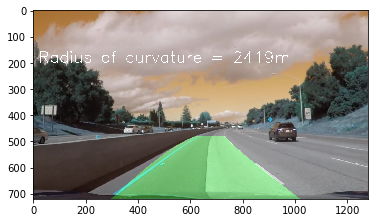

In [36]:
image = cv2.imread('Screenshot.png')
image = cv2.resize(image, (1280, 720), interpolation = cv2.INTER_AREA)
result = find_lane(image)
plt.imshow(result)
plt.show()

In [32]:
left_fit = np.array([ 1.22120921e-04, -1.49160585e-01,  3.29075123e+02])
right_fit = np.array([2.90910728e-04, -2.05179515e-01,  1.08280543e+03])

In [33]:
def fit_polynomial(binary_warped):
    global left_fit, right_fit
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     print(left_fit)
#     print(right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return left_fitx, right_fitx

In [34]:
# Load our image
def find_lane(image):
    if(image.shape != (720, 1280, 3)):
        image = cv2.resize(image, (1280, 720), interpolation = cv2.INTER_AREA)
    undistorted_image = distortion_correction(image)

    sobel_x = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    s_segment = hls_select(undistorted_image)
    final_combination = np.zeros_like(s_segment)
    final_combination[(s_segment == 1) | (sobel_x == 1)] = 1
    warped, dst, src = warp(final_combination)
    
    left_fitx, right_fitx = fit_polynomial(warped)

    unwarped = unwarp(final_combination, dst, src, left_fitx, right_fitx)
    result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
    cv2.putText(result, 'Radius of curvature = {}m'.format(measure_curvature(binary_warped, left_fit, right_fit)), (20,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return result

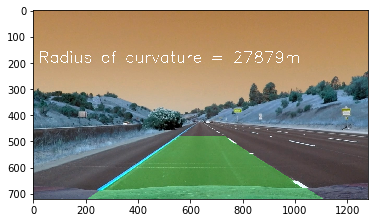

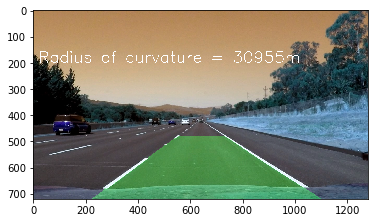

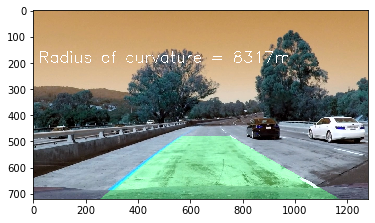

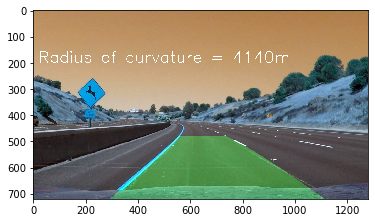

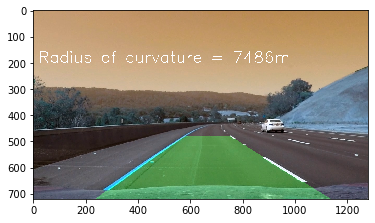

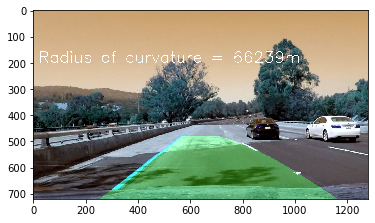

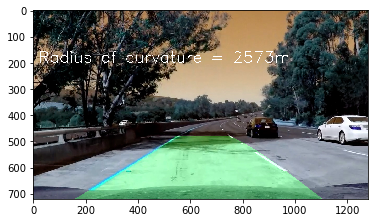

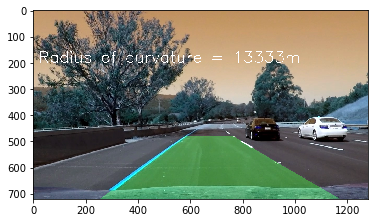

In [37]:
imgs = glob.glob('./test_images/*.jpg')
for i, img in enumerate(imgs):
    image = cv2.imread(img)
    result = find_lane(image)
    plt.imshow(result)
    cv2.imwrite('output_images/test'+str(i)+'.jpg',result)
    plt.show()